Resources Used
- wget.download('https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py')
- Setup https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

# 0. Setup Paths

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Create Label Map

In [2]:
labels = [{'name':'Telephone', 'id':1}, 
          {'name':'ILoveYou', 'id':2},
          {'name':'Family', 'id':3},
          {'name':'Yes', 'id':4},
          {'name':'No', 'id':5},
          {'name':'Money', 'id':6},
          {'name':'Help', 'id':7}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [10]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [20]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [6]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [8]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

A subdirectory or file Tensorflow\workspace\models\my_ssd_mobnet already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.


# 5. Update Config For Transfer Learning

In [4]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [5]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [6]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [10]:
config

{'model': ssd {
   num_classes: 7
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [7]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [16]:
pipeline_config.model.ssd.num_classes = 7
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [35]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [9]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=15000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=15000


# 7. Load Train Model From Checkpoint

In [6]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-16')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# TESTING

In [17]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [40]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

In [44]:
def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, thickness, display_str_list, use_normalized_coordinates)
    np.copyto(image, np.array(image_pil))
    
    
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    if thickness > 0:
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness,
              fill=color)
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                              text_bottom)],
            fill=color)
        draw.text(
            (left + margin, text_bottom - text_height - margin),
            display_str,
            fill='black',
            font=font)
        text_bottom -= text_height - 2 * margin

    
    


In [54]:
import collections
import six
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

def visualize_boxes_and_labels_on_image_array(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    keypoint_scores=None,
    keypoint_edges=None,
    track_ids=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    mask_alpha=.4,
    groundtruth_box_visualization_color='black',
    skip_boxes=False,
    skip_scores=False,
    skip_labels=False,
    skip_track_ids=False):
    
    
    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    box_to_instance_masks_map = {}
    box_to_instance_boundaries_map = {}
    box_to_keypoints_map = collections.defaultdict(list)
    box_to_keypoint_scores_map = collections.defaultdict(list)
    box_to_track_ids_map = {}
    final_label = 'empty'
    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]
    for i in range(boxes.shape[0]):
        if max_boxes_to_draw == len(box_to_color_map):
            break
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist())
            if instance_masks is not None:
                box_to_instance_masks_map[box] = instance_masks[i]
            if instance_boundaries is not None:
                box_to_instance_boundaries_map[box] = instance_boundaries[i]
            if keypoints is not None:
                box_to_keypoints_map[box].extend(keypoints[i])
            if keypoint_scores is not None:
                box_to_keypoint_scores_map[box].extend(keypoint_scores[i])
            if track_ids is not None:
                box_to_track_ids_map[box] = track_ids[i]
            if scores is None:
                box_to_color_map[box] = groundtruth_box_visualization_color
            else:
                display_str = ''
                if not skip_labels:
                    if not agnostic_mode:
                        if classes[i] in six.viewkeys(category_index):
                            class_name = category_index[classes[i]]['name']
                        else:
                            class_name = 'N/A'
                        display_str = str(class_name)
                final_label = display_str
                if not skip_scores:
                    if not display_str:
                        display_str = '{}%'.format(round(100*scores[i]))
                        final_label = display_str
                    else:
                        display_str = '{}: {}%'.format(display_str, round(100*scores[i]))
                if not skip_track_ids and track_ids is not None:
                    if not display_str:
                        display_str = 'ID {}'.format(track_ids[i])
                        final_label = track_ids[i]
                    else:
                        display_str = '{}: ID {}'.format(display_str, track_ids[i])

                box_to_display_str_map[box].append(display_str)
                if agnostic_mode:
                    box_to_color_map[box] = 'DarkOrange'
                elif track_ids is not None:
                    prime_multipler = _get_multiplier_for_color_randomness()
                    box_to_color_map[box] = STANDARD_COLORS[
                    (prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
                else:
                    box_to_color_map[box] = STANDARD_COLORS[
                      classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box
        if instance_masks is not None:
            draw_mask_on_image_array(
              image,
              box_to_instance_masks_map[box],
              color=color,
              alpha=mask_alpha
          )
        if instance_boundaries is not None:
            draw_mask_on_image_array(
              image,
              box_to_instance_boundaries_map[box],
              color='red',
              alpha=1.0
          )
        draw_bounding_box_on_image_array(
            image,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=0 if skip_boxes else line_thickness,
            display_str_list=box_to_display_str_map[box],
            use_normalized_coordinates=use_normalized_coordinates)
        if keypoints is not None:
            keypoint_scores_for_box = None
            if box_to_keypoint_scores_map:
                keypoint_scores_for_box = box_to_keypoint_scores_map[box]
            draw_keypoints_on_image_array(
              image,
              box_to_keypoints_map[box],
              keypoint_scores_for_box,
              min_score_thresh=min_score_thresh,
              color=color,
              radius=line_thickness / 2,
              use_normalized_coordinates=use_normalized_coordinates,
              keypoint_edges=keypoint_edges,
              keypoint_edge_color=color,
              keypoint_edge_width=line_thickness // 2)

    return final_label, image

In [104]:
PATH = os.path.join(IMAGE_PATH, 'test')
print('path', str(PATH))

y_pred=[]
y_act=[]

for img in os.listdir(PATH):
    f=os.path.join(PATH,img)
    temp=str(f[-3]+f[-2]+f[-1])
    if(temp=='jpg'):
        class_name = img.split('.')[0]
        if(class_name == 'Iloveyou'):
            class_name = 'ILoveYou'
        y_act.append(class_name)




        img = cv2.imread(f)
        image_np = np.array(img)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        
#         detection_list.append(detections['detection_classes'])
        
        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        label, _ = visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=5,
                    min_score_thresh=.8,
                    agnostic_mode=False)
        y_pred.append(label)

#         plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
#         plt.show()


path Tensorflow/workspace/images\test


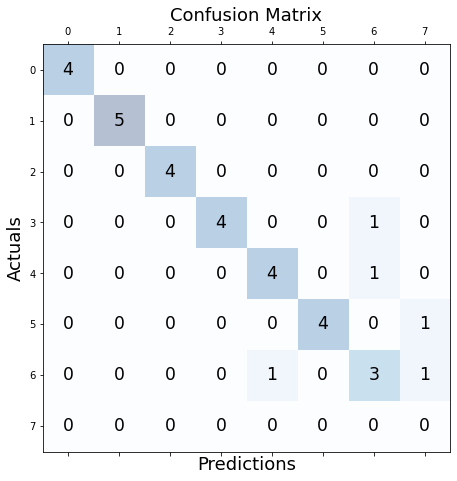

In [115]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC



conf_matrix = confusion_matrix(y_true=y_act, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 


plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [110]:
conf_matrix = metrics.confusion_matrix(y_act, y_pred, labels=['Telephone', 'ILoveYou', 'Family', 'Yes', 'No', 'Money', 'Help','empty'])


print(conf_matrix)

[[4 0 0 0 0 0 0 1]
 [0 4 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 3 1 0 0 1]
 [0 0 0 1 4 0 0 0]
 [0 0 0 1 0 4 0 0]
 [0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0]]


In [112]:
!pip install mlxtend

C:\Users\abhis\anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


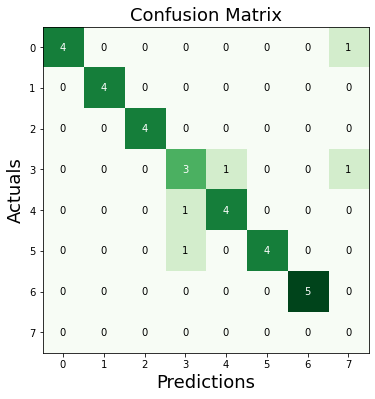

[[4 0 0 0 0 0 0 1]
 [0 4 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 3 1 0 0 1]
 [0 0 0 1 4 0 0 0]
 [0 0 0 1 0 4 0 0]
 [0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0]]
              precision    recall  f1-score   support

   Telephone       1.00      0.80      0.89         5
    ILoveYou       1.00      1.00      1.00         4
      Family       1.00      1.00      1.00         4
         Yes       0.60      0.60      0.60         5
          No       0.80      0.80      0.80         5
       Money       1.00      0.80      0.89         5
        Help       1.00      1.00      1.00         5
       empty       0.00      0.00      0.00         0

    accuracy                           0.85        33
   macro avg       0.80      0.75      0.77        33
weighted avg       0.91      0.85      0.88        33



C:\Users\abhis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abhis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abhis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [121]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(y_act, y_pred, labels=['Telephone', 'ILoveYou', 'Family', 'Yes', 'No', 'Money', 'Help','empty'])
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


print(metrics.confusion_matrix(y_act, y_pred, labels=['Telephone', 'ILoveYou', 'Family', 'Yes', 'No', 'Money', 'Help','empty']))

print(metrics.classification_report(y_act, y_pred, labels=['Telephone', 'ILoveYou', 'Family', 'Yes', 'No', 'Money', 'Help','empty']))

In [15]:
TRAINING_SCRIPT = 'python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=15000'

In [20]:
import os
PIPELINE_CONFIG = os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config')

In [21]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, CHECKPOINT_PATH,PIPELINE_CONFIG,CHECKPOINT_PATH)

In [22]:
command


'python python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=15000 --model_dir=Tensorflow/workspace/models/my_ssd_mobnet/ --pipeline_config_path=Tensorflow\\workspace\\models\\my_ssd_mobnet\\pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet/'

# 8. Detect in Real-Time

In [9]:
import cv2 
import numpy as np

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [118]:
cap.release()

In [117]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [15]:
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.65,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [16]:
detections = detect_fn(input_tensor)

In [18]:
detections

{'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.646052  , 0.9877914 ],
         [0.        , 0.        , 0.76192284, 1.        ],
         [0.        , 0.10064369, 0.6441323 , 1.        ],
         [0.        , 0.        , 0.76192284, 1.        ],
         [0.        , 0.38195086, 0.71383697, 1.        ],
         [0.        , 0.        , 0.76192284, 1.        ],
         [0.        , 0.10064369, 0.6441323 , 1.        ],
         [0.        , 0.        , 1.        , 0.78552365],
         [0.72764325, 0.8493485 , 0.97873306, 1.        ],
         [0.        , 0.        , 0.6484978 , 1.        ],
         [0.        , 0.38195086, 0.71383697, 1.        ],
         [0.        , 0.10064369, 0.6441323 , 1.        ],
         [0.        , 0.        , 1.        , 1.        ],
         [0.        , 0.        , 0.76192284, 1.        ],
         [0.        , 0.32266375, 0.6880357 , 1.        ],
         [0.        , 0.15516886, 0.863108

In [17]:
from matplotlib import pyplot as plt

In [1]:

command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

NameError: name 'TRAINING_SCRIPT' is not defined

In [2]:
!python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet

^C
